#TODO
1. What to do with NAs
    - 160 out of 3000 is in fraud transactions
    - More description in cell with count of missing values in fraud transactions
2. Delete ID columns
3. Variable selection
4. Time series na kolumne 'event timestamp' (?) lub całkowite zaufanie ze model dobrze zlapie
5. Bez komplikacji raczej wbudowanych na twardo reguł.
6. Do EDA outliers itd.
    - investigate more the outliers, check if they are in frauds.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Loading data

In [27]:
path = os.getcwd() + '/data/fraud_challenge_150k.csv'
data = pd.read_csv(path)

# Exploration

In [8]:
data.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [13]:
data.columns

Index(['account_age_days', 'transaction_amt', 'transaction_adj_amt',
       'historic_velocity', 'ip_address', 'user_agent', 'email_domain',
       'phone_number', 'billing_city', 'billing_postal', 'billing_state',
       'card_bin', 'currency', 'cvv', 'signature_image', 'transaction_type',
       'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name',
       'billing_address', 'merchant_id', 'locale', 'tranaction_initiate',
       'days_since_last_logon', 'inital_amount', 'EVENT_LABEL'],
      dtype='object')

In [29]:
data['EVENT_LABEL'].value_counts()

EVENT_LABEL
legit    141836
fraud      8164
Name: count, dtype: int64

In [30]:
data['EVENT_LABEL'] = [0 if x == 'legit' else 1 for x in data['EVENT_LABEL']]

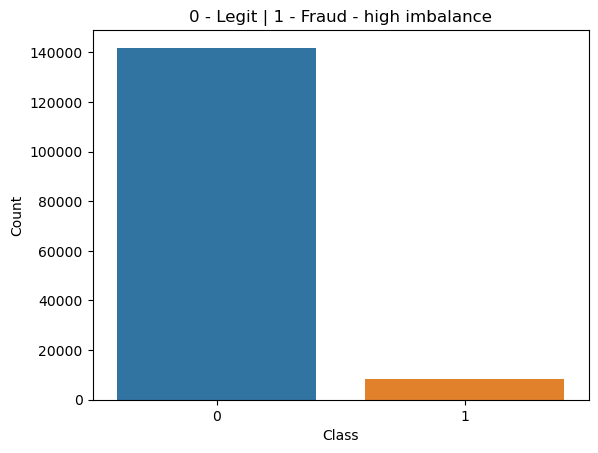

In [64]:
sns.countplot(data, x='EVENT_LABEL')
plt.title('0 - Legit | 1 - Fraud - high imbalance')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [49]:
all_rows = data['EVENT_LABEL'].count()
fraud_rows = data['EVENT_LABEL'].sum()
legit_rows = all_rows - fraud_rows
print(f'There is {round((fraud_rows/all_rows)*100, 2)}% of fraud transactions, which is {fraud_rows} transactions.')
print(f'There is {round((legit_rows/all_rows)*100, 2)}% of legit transactions, which is {legit_rows} transactions.')

There is 5.44% of fraud transactions, which is 8164 transactions.
There is 94.56% of legit transactions, which is 141836 transactions.


In [63]:
# Rows with legit transactions and missing data can be deleted. Those who has fraud should be looked at more, after variable selection.
# Those with irrelevant columns can be supplemented with some default value, and those with important data missing imputed or deleted.
missing_rows = data[data.isna().any(axis=1)]
missing_fraud = missing_rows[missing_rows['EVENT_LABEL'] == 1]
missing_fraud.isna().sum()

account_age_days          6
transaction_amt           8
transaction_adj_amt      10
historic_velocity         3
ip_address                5
user_agent                7
email_domain              2
phone_number              5
billing_city              5
billing_postal            8
billing_state             7
card_bin                  8
currency                  7
cvv                      11
signature_image           7
transaction_type          5
transaction_env           2
EVENT_TIMESTAMP           6
applicant_name            4
billing_address          10
merchant_id               5
locale                    6
tranaction_initiate       4
days_since_last_logon     9
inital_amount            10
EVENT_LABEL               0
dtype: int64

In [65]:
data.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount,EVENT_LABEL
count,149892.000000,149870.000000,149886.000000,149885.000000,149876.000000,149872.000000,149864.000000,149872.000000,150000.000000
mean,4645.751995,2521.458944,54.202434,4702.200033,50190.088160,41837.521512,49.866392,7998.025275,0.054427
std,1153.816155,604.524161,10.070401,1188.476704,28378.078852,10080.587192,29.204766,4047.071560,0.226858
min,1.000000,5.000000,1.000000,50.000000,503.000000,6040.000000,0.000000,1000.000000,0.000000
25%,3824.000000,2103.000000,48.000000,3872.000000,25314.000000,35386.000000,24.000000,4487.000000,0.000000
50%,4667.000000,2544.000000,55.000000,4730.000000,50117.000000,42086.000000,50.000000,8002.000000,0.000000
75%,5476.000000,2951.000000,61.000000,5548.000000,74338.000000,47374.000000,75.000000,11494.000000,0.000000
max,9119.000000,4999.000000,99.000000,9999.000000,99950.000000,67639.000000,100.000000,15000.000000,1.000000


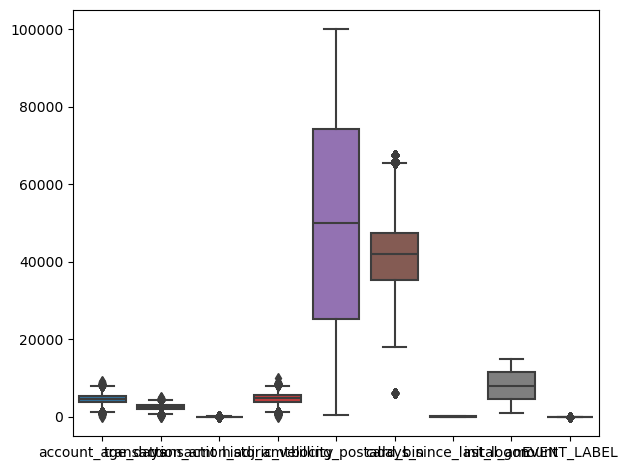

In [67]:
sns.boxplot(data)
plt.tight_layout() 
plt.show()

## Cleaning